In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1
from phase_2.scripts.strategies.meta.meta_allocator_v1 import build_regime_features, build_meta_raw_returns
from phase_2.scripts.strategies.meta.risk_targeting_v1 import apply_vol_targeting

In [2]:
spy = pd.read_parquet("../data/processed/spy_daily.parquet")
spy["date"] = pd.to_datetime(spy["date"])
spy = spy.sort_values("date").reset_index(drop=True)

spy["year"] = spy["date"].dt.year
spy.head()


,date,adj_close,close,volume,year
0,2010-01-04,85.279190,113.330002,118944600,2010
1,2010-01-05,85.504951,113.629997,111579900,2010
2,2010-01-06,85.565163,113.709999,116074400,2010
3,2010-01-07,85.926361,114.190002,131091100,2010
4,2010-01-08,86.212273,114.570000,126402800,2010


In [3]:
def sharpe_ratio(daily_ret: np.ndarray) -> float:
    daily_ret = np.asarray(daily_ret, dtype=float)
    if np.nanstd(daily_ret) == 0:
        return np.nan
    return np.sqrt(252) * np.nanmean(daily_ret) / np.nanstd(daily_ret)

def max_drawdown(equity: np.ndarray) -> float:
    equity = np.asarray(equity, dtype=float)
    peak = np.maximum.accumulate(equity)
    drawdown = equity / peak - 1.0
    return np.nanmin(drawdown)


In [4]:
year_results = []
daily_meta_all = []

years = sorted(spy["year"].unique())

for test_year in years:
    train = spy[spy["year"] < test_year].copy()
    test  = spy[spy["year"] == test_year].copy()

    # -------------------------------
    # 0. Skip years without enough history
    # -------------------------------
    if len(train) < 500 or len(test) == 0:
        continue

    # -------------------------------
    # 1. Run strategies for this test year
    # -------------------------------
    trend_out = run_trend_strategy_v1(
        test,
        train_df=train,
        prediction_threshold=0.0,
        hold_days=5,
        cost_per_side_bps=5.0,
    )

    meanrev_out = run_meanrev_strategy_v1(
        test,
        entry_ret_5d_threshold=-0.02,
        hold_days=3,
        max_vol_annual=0.40,
        cost_per_side_bps=5.0,
    )

    # -------------------------------
    # 2. Build allocator regime features (test year only)
    # -------------------------------
    regime = build_regime_features(test)

    # -------------------------------
    # 3. Meta raw returns (choose TREND/MEANREV/CASH)
    # -------------------------------
    meta = build_meta_raw_returns(trend_out, meanrev_out, regime)

    # -------------------------------
    # 4. Vol targeting at meta level
    # -------------------------------
    vt = apply_vol_targeting(
        meta["meta_raw_ret"],
        target_vol_annual=0.10,
        lookback=20,
        max_leverage=1.0,
    )
    meta["lev"] = vt["lev"]
    meta["meta_ret"] = vt["meta_ret"]
    meta["year"] = test_year

    # -------------------------------
    # 5. Per-year metrics
    # -------------------------------
    equity = (1 + meta["meta_ret"]).cumprod().values

    # State proportions
    state_frac = meta["state"].value_counts(normalize=True).to_dict()

    summary = {
        "year": test_year,
        "sharpe": sharpe_ratio(meta["meta_ret"].values),
        "total_return": equity[-1] - 1.0,
        "max_drawdown": max_drawdown(equity),
        "pct_trend": state_frac.get("TREND", 0.0),
        "pct_meanrev": state_frac.get("MEANREV", 0.0),
        "pct_cash": state_frac.get("CASH", 0.0),
    }

    year_results.append(summary)
    daily_meta_all.append(meta)


In [5]:
meta_summary = pd.DataFrame(year_results).sort_values("year").reset_index(drop=True)
meta_summary


,year,sharpe,total_return,max_drawdown,pct_trend,pct_meanrev,pct_cash
0,2012,0.137604,0.006585,-0.088603,0.336000,0.156000,0.508000
1,2013,1.746732,0.134283,-0.056151,0.638889,0.063492,0.297619
2,2014,1.184780,0.082964,-0.038728,0.607143,0.071429,0.321429
3,2015,0.428139,0.028234,-0.058300,0.369048,0.115079,0.515873
4,2016,1.378210,0.083083,-0.033794,0.583333,0.023810,0.392857
5,2017,2.578571,0.142001,-0.020047,0.725100,0.000000,0.274900
6,2018,-0.604317,-0.049522,-0.111282,0.406375,0.207171,0.386454
7,2019,1.981762,0.142892,-0.043469,0.555556,0.119048,0.325397
8,2020,2.680575,0.216650,-0.030493,0.525692,0.055336,0.418972
9,2021,1.648446,0.134048,-0.045939,0.662698,0.055556,0.281746


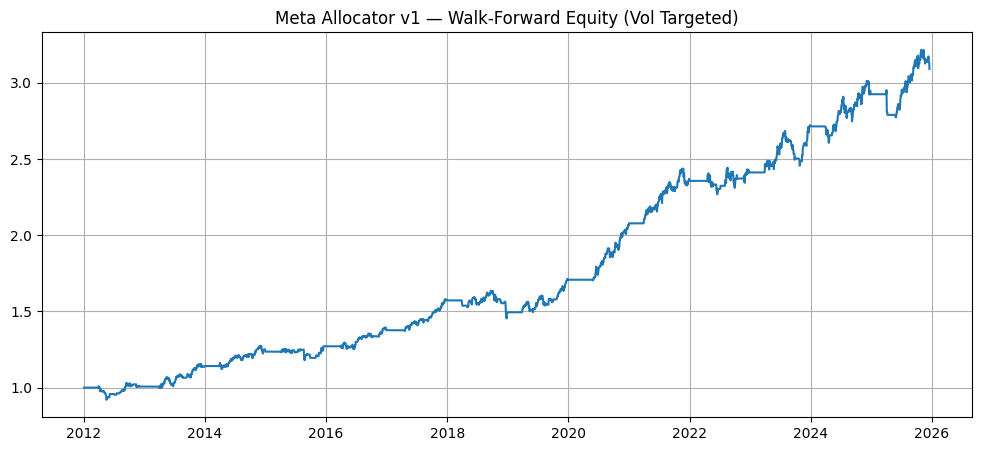

In [6]:
meta_daily = pd.concat(daily_meta_all).sort_values("date").reset_index(drop=True)
equity = (1 + meta_daily["meta_ret"]).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(meta_daily["date"], equity)
plt.title("Meta Allocator v1 — Walk-Forward Equity (Vol Targeted)")
plt.grid(True)
plt.show()


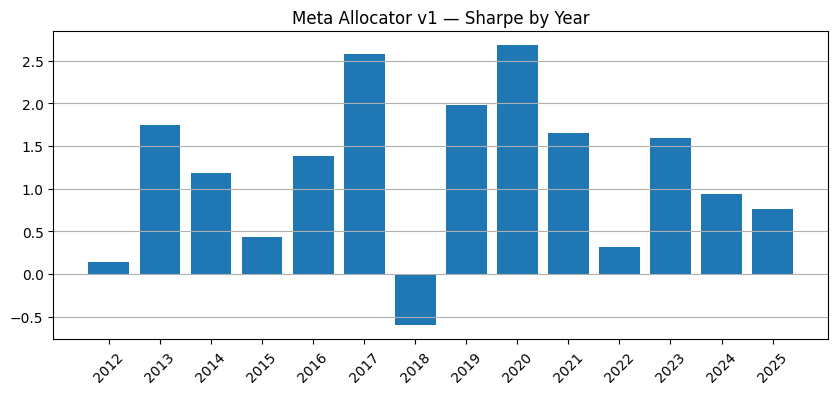

In [7]:
plt.figure(figsize=(10, 4))
plt.bar(meta_summary["year"].astype(str), meta_summary["sharpe"])
plt.title("Meta Allocator v1 — Sharpe by Year")
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.show()


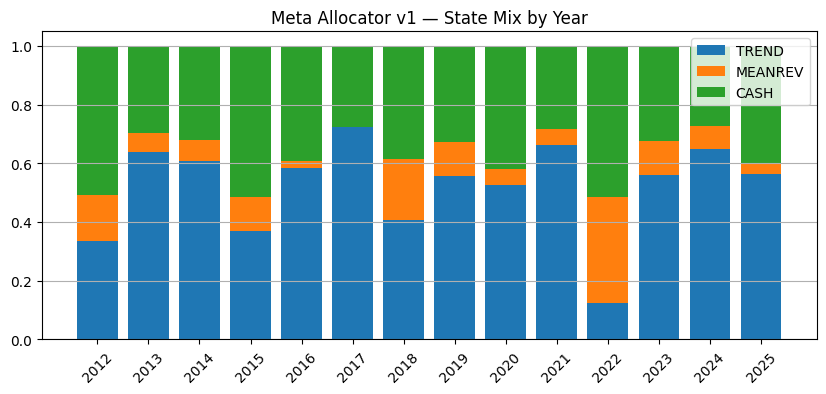

In [8]:
years_str = meta_summary["year"].astype(str)

trend = meta_summary["pct_trend"].values
meanrev = meta_summary["pct_meanrev"].values
cash = meta_summary["pct_cash"].values

plt.figure(figsize=(10, 4))
plt.bar(years_str, trend, label="TREND")
plt.bar(years_str, meanrev, bottom=trend, label="MEANREV")
plt.bar(years_str, cash, bottom=trend + meanrev, label="CASH")

plt.title("Meta Allocator v1 — State Mix by Year")
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.legend()
plt.show()


In [19]:
year_to_inspect = meta_summary["year"].iloc[6]  # change this manually
inspect = meta_daily[meta_daily["year"] == year_to_inspect].copy()

inspect["state"].value_counts(normalize=True)


state
TREND      0.406375
CASH       0.386454
MEANREV    0.207171
Name: proportion, dtype: float64

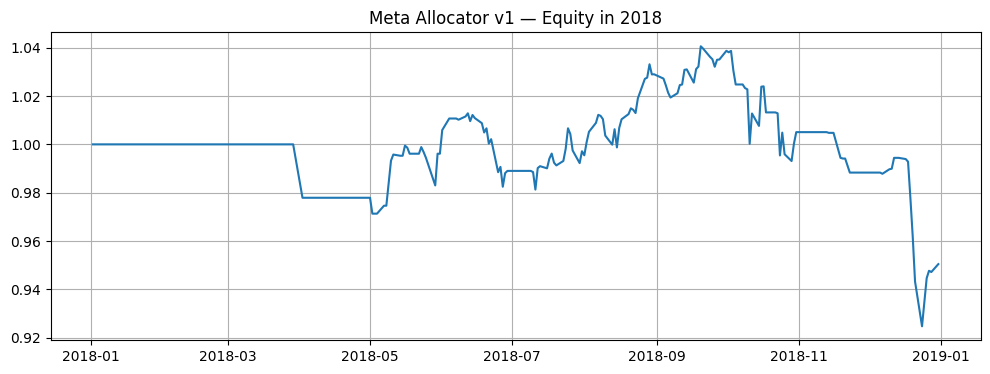

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(inspect["date"], (1 + inspect["meta_ret"]).cumprod())
plt.title(f"Meta Allocator v1 — Equity in {year_to_inspect}")
plt.grid(True)
plt.show()
